# Lab Three: Exploring Image Data

#### Saahil Deshpande, Jeremy Holcombe, Ata Khiabani, Daniel Perez

## Business Understanding

   Much of modern e-commerce is driven by the use of photos. Modern e-commerce platforms present elegantly captured photographs of their products to generate demand for those products, or at least to simplify the users' efforts in identifying the products in which they are interested. This interaction, however, is overwhelmingly one-sided. We cannot simply project the image we have in our mind of a particular product into the search bar of our favorite store website. While we humans are able to effortlessly extract information about a product once an image is presented to us, we are generally confined to using written language to _describe_ the image we have in mind and hope the search algorithm will select the right products.

   While we are probably a few years away from connecting our mind's eye to the internet, much of the friction associated with searching for products on the web today could be minimized with more sophisticated search algorithms. The ability to input a detailed description of an image into a search bar and be presented with an accurate array of candidates would be a welcome enhancement to the current e-commerce experience.

   In this lab, we explore a data set representing one potential use case of the aforementioned facility. The data set consists of 70,000 labeled images of fashion items, drawn from the German fashion-oriented e-commerce platform, Zalando. The images represent ten different articles of clothing: t-shirt/top, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot. The data set was originally created as a replacement for the famous computer vision benchmarking data set, MNIST, which consists of handwritten digits. As a result, the images are downscaled to a 28 by 28 pixel representation to enable faster computations and, by extension, more flexibility in implementing a range of machine learning algorithms for the purpose of comparison.

   The lower quality of the images makes it more difficult to train an algorithm that could accurately translate a detailed description of a product (e.g., _brown overcoat with three pockets and a narrow zipper_) into matching images of recommended products, as we envisioned above. Rather, the data set presents more of a _proof of concept_ opportunity, enabling us to craft an algorithm that is highly accurate at classifying images of products as the _broad category_ of products they represent and could ultimately be _extended_ to work with higher resolution images down the road.
One possible extension might involve creating a set of filters for different features that may appear on products to assist in the identification of images, rather than simply matching keywords with manually added metadata. The classification model could then be extended to parse the words included in the search query and apply these labeled filters to identifying images of products that contain these elements. Using the example from before, filters could be created for pockets and zippers, which would then identify only coats with such pockets and zippers.

   Even without extending the algorithm or creating a higher resolution data set, a model trained on this data set could provide significant efficiency gains for companies that _aggregate_ fashion products from other retailers and present images of those products along with hyperlinks to those other companies. While many retailers will provide product information with their APIs or in the DOM, this is not a guarantee. The ability to efficiently and accurately classify and label images of products from other retailers would save the company resources and provide an enhanced search experience for the user.
Naturally, if the *ultimate* goal is to provide users of an e-commerce website the ability to describe a product, _in fine detail_, and be served up matching products, then the accuracy of an algorithm intended to classify images with _coarse detail_ should be quite high. Machine learning researchers were able to achieve classification accuracy of 99.7% using convolutional neural networks on the original MNIST data set. While those images were also rendered in 28x28 grayscale (as are these images), the classes (the numbers 0-9) are a fair bit more distinct than those of this data set (i.e., t-shirts, shirts, and coats all have the same general form). Therefore, we would not necessarily expect an algorithm, no matter how finely tuned, to achieve the same level of accuracy on this data set. Instead, we would lower our expectations to 90%-97% (NOTE: Some individuals have already achieved >96% accuracy on this data set). From a practical perspective, it is important that this accuracy be achieved for two reasons: (1) as we mentioned before, the true use case comes from classifying images in much greater detail, thus requiring _at least_ a highly accurate _broad category_ classifier; (2) modern consumers have fairly low tolerance for inaccurate search facilities (just ask Yahoo).

   An alternative method would be for e-commerce companies to add metadata in minute detail for every product, a laborious task that is not scalable and must be performed for every product that enters its inventory. Rather, creating a smaller set of filters for common elements of products and using a classifier to identify products that contain these elements would be much faster and more cost efficient over time. Even with the intermediate goal of classifying broad categories of fashion images that could be achieved with this data set, an automatic classification of images scraped from websites of other retailers would save resources that would otherwise be spent dealing with the often distinct layouts of the DOM or API.

Citation: Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747

## Preparing the Data

In [2]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

import numpy as np
import pandas as pd
import copy

from scipy import ndimage as ndi
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import RandomizedPCA

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import pairwise_distances

from ipywidgets import widgets
from ipywidgets import fixed

from skimage.io import imshow
from skimage.filters import sobel_h, sobel_v
from skimage.feature import daisy
from skimage.filters import gabor_kernel

import matplotlib.pyplot as plt
%matplotlib inline

This function, suggested by the dataset creators, loads, unzips and flattens the image to `NumPy` 1-dimensional arrays.

In [1]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

We will use the function we just defined to read the images and labels into X and y, respectively. For this exercise, we will just use the test set as it contains only 10,000 images (vs. 60,000 for the training set). Since we are only exploring the data at this point, this will speed up processing.

In [2]:
# Read in feature matrix (images) and target labels (y)
X, y = load_mnist('data/fashion', kind='t10k') # using the test set for faster processing

# Specify the height and width of images in pixels
h, w = 28, 28

Let's get a better understanding of the data we're working with.

In [5]:
# Explore the dimensions of the dataset
print("There are {} images, each with {} features (i.e., total pixels).".format(X.shape[0], X.shape[1]))

There are 10000 images, each with 784 features (i.e., total pixels).


This is what a single image looks like in terms of its pixel values, as the images are 28x28 pixels and there are only 784, it is implied that the images are meant to be rendered in a monochromatic scale.

In [6]:
first_image = pd.DataFrame(np.reshape(X[0], (h, w)))
first_image

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,3,1,0,0,7,0,37,0,0
8,0,0,0,0,0,0,0,0,0,0,...,11,0,0,0,0,0,0,119,0,0
9,0,0,0,0,0,0,0,0,0,0,...,110,0,0,0,0,22,93,106,0,0


Here's that same image rendered in grayscale, mapping the pixel intensity values shown above to a spectrum of grayscale from black (0) to white (255).

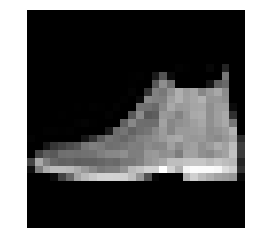

In [7]:
# Plot pixel values in grayscale
plt.imshow(first_image, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

Let's now view several of our images with their associated labels. Right now, the labels are represented by integers, so we will first map the integers to label values in a dictionary, then vectorize it so we can use it with `NumPy` arrays.

In [8]:
# Convert labels to human-readable form
def y_to_labels(y):
    y_labels = {0: "T-shirt/top",
                1: "Trouser",
                2: "Pullover",
                3: "Dress",
                4: "Coat",
                5: "Sandal",
                6: "Shirt",
                7: "Sneaker",
                8: "Bag",
                9: "Ankle boot"
               }
    return(y_labels[y])
y_to_labels = np.vectorize(y_to_labels)

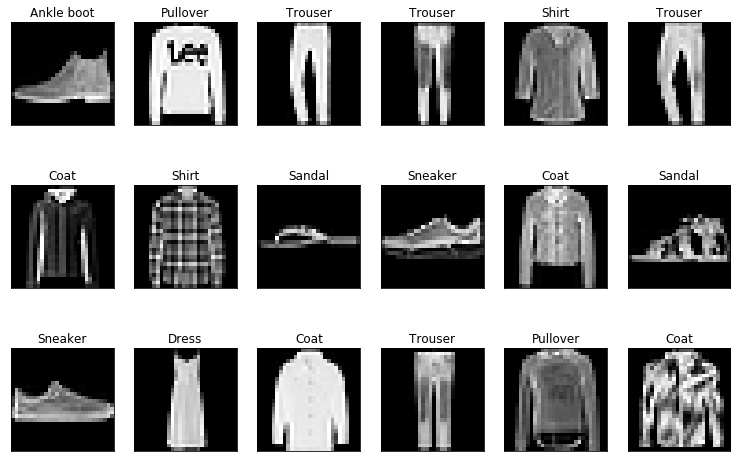

In [9]:
# Source: Eric Larson, Dimensionality Reduction & Images lecture
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X, y_to_labels(y), h, w) # defaults to showing a 3 by 6 subset of the images

## Dimensionality Reduction

As stated above, each instance (or image) of the dataset consists of 784 features (or pixels). If we think of how the features change along all of the instances, that is, if we think of the variance of the feature over the whole dataset, we would discover that some of these features may carry a lot of information, while some others may not vary as drastically. For instance, pixels in the center of the images tend to more often be white (because an article of clothing is centered there), while pixels near the borders of the images tend to more often be black (no objects in the image).

Furthermore, if we think of each feature as a dimension of a hyperspace, we could find vectors (or linear combinations of features) that can point along the direction where more information exists (or, in statistical terms, in the direction of most variance). Starting with a vector that points along the direction where there's more information (i.e., the eigenvector) with a magnitude (i.e., eigenvalue), each subsequent vector would point along a direction with a smaller quantity of information. The first vector mentioned, is called the first principal component, or PC1, while the subsequent vectors are PC2, PC3, and so forth.

But why would we need to find these principal components? The answer lies in a concept known as dimensionality reduction. If we know the principal components point at the directions with the largest variance, we could project each of our instances along these vectors. The result would be a representation of our original instances, but with a new set of features that maximize the variance explained. We can use a subset of this new set of features to represent our original 784 features, while retaining most of the information from the original image.

The subset of new features derived from the projection of the original features on the principal components can encode an almost equivalent amount of information, while consisting of fewer elements. Statistical learning algorithms may take advantage of these reduced set of inputs by:
- Preventing overfitting
- Avoiding the chances of finding spurious correlations between the features and the response
- Reducing computation

### Linear Dimensionality Reduction

There are several methods for performing dimensionality reduction using principal component analysis. The most natural place to begin is performing the reduction linearly with full PCA.

We use scikit-learn's PCA module to perform PCA on the full data set. If we wanted, we could obtain a full set of principal components matching in number our original set of features (784). However, with just a small subset of these principal components, we can explain the majority of the variance from the original data set. Here we will extract just 50 PCs in order to determine how many we ultimately need to explain a sufficient amount of the variance across the features.

#### PCA

In [10]:
n_components = 50
print("Extracting the top {} eigenvectors from {} fashion items, using linear PCA.".format(
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(X)

Extracting the top 50 eigenvectors from 10000 fashion items, using linear PCA.
Wall time: 426 ms


PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

We can now plot the cumulative variance explained by the most important _n_ principal components.

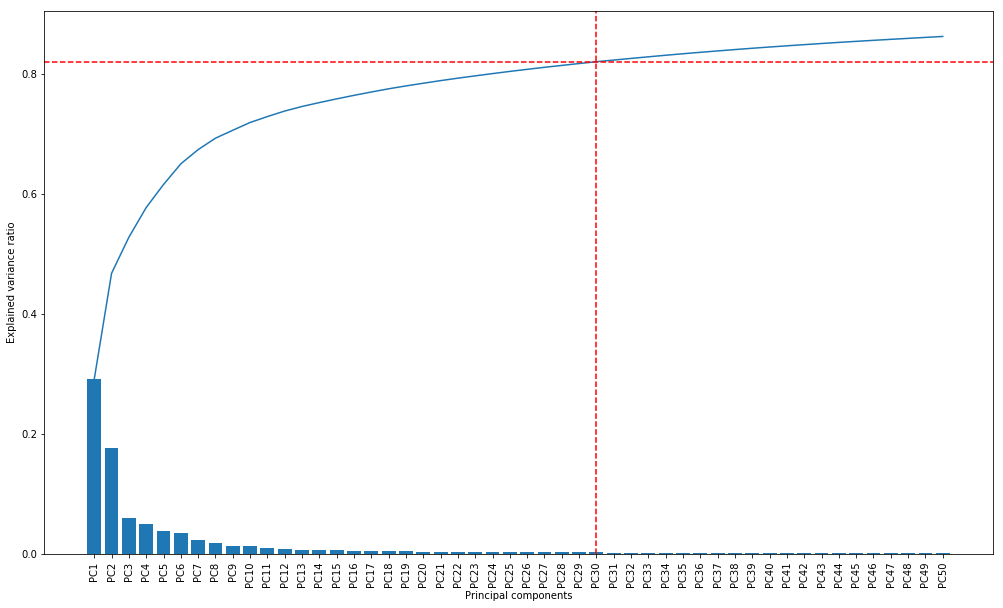

In [11]:
var_ratio = pca.explained_variance_ratio_
x_scale = np.arange(var_ratio.size) + 1
x_labels = ["PC" + str(i) for i in x_scale]

plt.figure(figsize=(17, 10))
plt.bar(x_scale, var_ratio)
plt.plot(x_scale, np.cumsum(pca.explained_variance_ratio_))
plt.axhline(pca.explained_variance_ratio_[:30].sum(), color='r', linestyle="--")
plt.axvline(30, color='r', linestyle="--")
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.xticks(x_scale, x_labels, rotation='vertical')
plt.show()

In [12]:
# Re-instantiate our PCA object with the chosen number of components
pca = PCA(n_components=30)
pca.fit(X)

# Proportion of variance explained by first 30 principal components
pca.explained_variance_ratio_.sum()

0.82071693997106143

As we can see from the chart above, the first thirty principal components explain 82% of the variance of the features in the image, with the first principal component explaining almost 30%. The rule of thumb generally used for determining the number of principal components to retain is to keep enough such that at least 80% of the variance is explained. The first thirty, in our case, meets this criteria.

But what do these principal components mean? What do they look like? Well if we take the principal components (consisting of a linear combination of the 784 original features) and plot them as a 28x28 grid of monochromatic pixels we can see what these "eigenitems" look like. In theory, we would be looking at images that represent distinctive features of the dataset as a whole.

In [13]:
eigenitems = pca.components_.reshape((30, h, w))

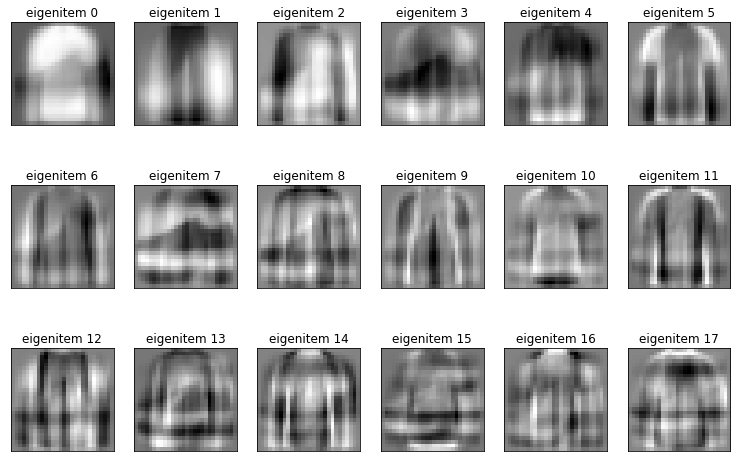

In [14]:
eigenitem_titles = ["eigenitem %d" % i for i in range(eigenitems.shape[0])]
plot_gallery(eigenitems, eigenitem_titles, h, w)

Let's take the first "eigenitem" built from the first principal component and analyze it more closely:

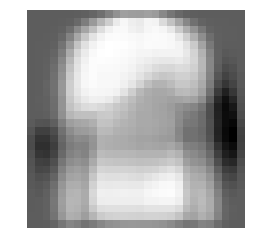

In [15]:
# Plot pixel values in grayscale
plt.imshow(eigenitems[0], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

The image above contains the silhouettes of elements that could be worn in the upper area of the body (shirts, t-shirts, pullovers, etc.) with that of footwear in white and black respectively. From this picture we can conclude that items like shirts are objectively (and measurably) the most different when compared with footwear.

Continuing with our discussion, let's recreate an image based on the 30 features resulting from the principal component analysis after reverting it to its original size.

In [16]:
# Reconstruct an image from a PCA-transformed representation
def reconstruct_image(trans_obj, org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

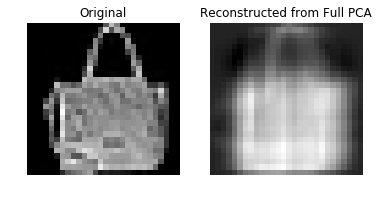

In [17]:
idx_to_reconstruct = 2000 # arbitrary item selected from the 10,000 items in the test set
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X[idx_to_reconstruct].reshape(1, -1))

plt.subplot(1,2,1)
plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.axis('off')
plt.title('Original')
plt.grid()
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.axis('off')
plt.title('Reconstructed from Full PCA')
plt.grid()

While we have lost some image quality, we can tell that the image is in fact, a bag. 

#### Randomized PCA

Since we are dealing with a fairly manageable data set, full PCA is not computationally prohibitive. However, if we were to scale the data set to include higher resolution images, we may run into challenges with full PCA. In this case, we might choose to do a randomized PCA instead.

In [18]:
n_components = 30
print ("Extracting the top {} eigenitems from {} fashion items, using randomized PCA.".format(
    n_components, X.shape[0]))

rpca = PCA(n_components = n_components, svd_solver='randomized')
%time rpca.fit(X)

Extracting the top 30 eigenitems from 10000 fashion items, using randomized PCA.
Wall time: 382 ms


PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

### Non-linear Dimensionality Reduction

#### Kernel PCA

The dataset we are analyzing has too many features to compute a kernelized PCA, it takes even more to optimize for the gamma parameter for the radial basis function kernel. For this reason we will try to subset the data and perform a grid search of the gamma parameter on the reduced dataset, then we will train for accuracy an select the gamma that maximizes the accuracy in our dataset.

In [19]:
#Sub Sample
n = 100
X_sub = np.zeros(shape=(10*n,X.shape[1]))
y_sub = np.zeros(10*n)

#For each class in the dataset
for i in np.unique(y):
    _x = X[y==i] #Extract all of the instances that share the class
    _x = _x[np.random.choice(_x.shape[0], n)] #Grab a sample of the subset of size n
    X_sub[i*n:(i*n+n)] = _x #Add the sample to the final subset
    y_sub[i*n:(i*n+n)] = [i]*n #Add the new labels of the final subset

In [20]:
n_components = 30 #Extract only the first 30 components.
print ("Extracting the top {} eigenitems from {} fashion items, using kernel PCA.".format(n_components, X_sub.shape[0]))

gamma_range = np.logspace(-9, 3, 13) #Initialize the grid for gammas on a log space
max_gamma = 0
max_accuracy = 0

#For each gamma in the grid, extract the Kernel PCs and fit a model to compare accuracy between hyperparameter values.
for gamma in gamma_range:
    kpca = KernelPCA(n_components=n_components, kernel='rbf', fit_inverse_transform=True, gamma=gamma)
    kpca.fit(X_sub)
    clf_kpca = LogisticRegression() 
    clf_kpca.fit(kpca.transform(X), y)
    y_pred_kpca = clf_kpca.predict(kpca.transform(X))
    cur_accuracy = accuracy_score(y, y_pred_kpca)    
    if cur_accuracy > max_accuracy:
        max_gamma = gamma    
        max_accuracy = cur_accuracy
        print("Accuracy for the model with gamma %s is %s"%(gamma, cur_accuracy))

Extracting the top 30 eigenitems from 1000 fashion items, using kernel PCA.
Accuracy for the model with gamma 1e-09 is 0.7008
Accuracy for the model with gamma 1e-08 is 0.752
Accuracy for the model with gamma 1e-07 is 0.7749


In [21]:
print("The max accuracy obtained was %s with a gamma of %s."%(max_accuracy, max_gamma))

The max accuracy obtained was 0.7749 with a gamma of 1e-07.


We can then run the kernel PCA on the original dataset with the optimized gamma.

In [22]:
n_components = 30
print ("Extracting the top {} eigenitems from {} fashion items, using kernel PCA.".format(
    n_components, X.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=max_gamma)
%time kpca.fit(X)

Extracting the top 30 eigenitems from 10000 fashion items, using kernel PCA.
Wall time: 6min 21s


KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=9.9999999999999995e-08,
     kernel='rbf', kernel_params=None, max_iter=None, n_components=30,
     n_jobs=1, random_state=None, remove_zero_eig=False, tol=0)

As we have now the new features derived from the Kernel PCA. We can reconstruct the same image to analyze the results.

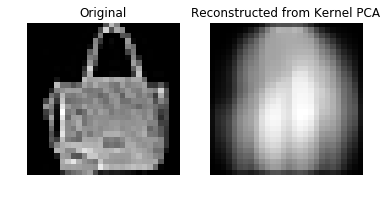

In [23]:
idx_to_reconstruct = 2000 # arbitrary item selected from the 10,000 items in the test set
low_dimensional_representation, reconstructed_image = reconstruct_image(kpca,X[idx_to_reconstruct].reshape(1, -1))

plt.subplot(1,2,1)
plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.axis('off')
plt.title('Original')
plt.grid()
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.axis('off')
plt.title('Reconstructed from Kernel PCA')
plt.grid()

It appears that the Kernel PCA that we chose to represent this data is not optimal. Even though we optimized the gamma value, we can observe that the radial basis function does not do a good job.

#### Compare dimensionality reduction representations

Now that we have our original dataset reduced with both linear and non-linear methods. We can benchmark the efficiency of the methods. For this, we will use three methodologies (subjective, reconstruction mean absolute error and modeling).

- Subjective: We can reconstruct the images from the different features and subjectively assess which one worked better.

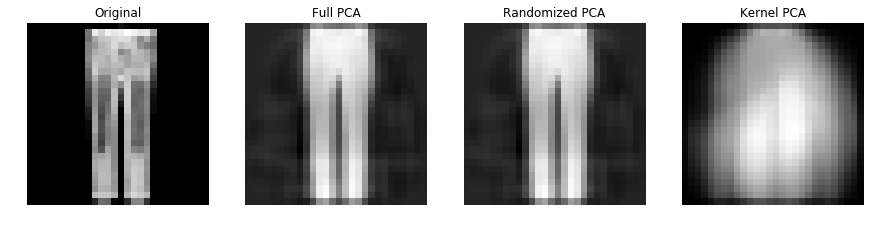

In [24]:
def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image_pca = pca.inverse_transform(pca.transform(X[idx_to_reconstruct].reshape(1, -1)))
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(X[idx_to_reconstruct].reshape(1, -1)))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct].reshape(1, -1)))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image_pca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.axis('off')
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)    
    plt.title('Randomized PCA')    
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.axis('off')
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,30,1),__manual=True)
plt.show()

On the images above, we can see that the model reconstructed from the full PCA yields the best image reconstructions. This is to be expacted on the training set when compared to the randomized PCA as we are using more information to extract the components. The surprise comes with the kernel PCA, the image reconstruction is unidentifiable. As stated above, it appears that the selected kernel does not work for this dataset.

- Reconstruction Mean Absolute Error: This time, we will reconstruct the images as before but calculate the mean absolute error between each method and the original by calculating the mean difference in pixel intensities.

In [25]:
X_pca = pca.inverse_transform(pca.transform(X))
X_rpca = rpca.inverse_transform(rpca.transform(X))
X_kpca = kpca.inverse_transform(kpca.transform(X))

In [26]:
print("Mean Absolute Error of PCA: %s"%(np.mean(np.abs(X - X_pca))))
print("Mean Absolute Error of Randomized PCA: %s"%(np.mean(np.abs(X - X_rpca))))
print("Mean Absolute Error of Kernel PCA: %s"%(np.mean(np.abs(X - X_kpca))))

Mean Absolute Error of PCA: 20.4393901277
Mean Absolute Error of Randomized PCA: 20.441552056
Mean Absolute Error of Kernel PCA: 58.982529222


It appears as if the least mean amount of reconstruction error is obtained by the PCA. This is to be expected, the PCA method utilized all of the information available in the dataset to generate the principal components on which to project the original features. The randomized PCA only uses a subset of these features resulting in a loss of information. Finally, as we observed, a radial basis function kernel was not optimal for this specific dataset.

But what does all of this mean in the context of our business necessity. We clearly can't use the subjective measure and a reconstruction error does not tells us a lot about the efficiency of our model...

- Modeling: This benchmarking methodology consists on training a different classification model with each of our datasets. Only then we will be able to compare characteristics such as training time and accuracy.

Our reference for the comparison will be a logistic regression model trained with the original data set.  
\* Note that since the training matrix is too large, we have opted to use a stochastic gradient descent method. The real statistcs of the full model are: 12 minutes 49 seconds of training time and 94.7% accuracy.  
\*\* Note that we have chosen to keep 30 features for each of our model to have a fair comparison in terms of training time and predictive power.

Let's compare training times for each model:

In [28]:
clf = SGDClassifier(loss="log")
%time clf.fit(X, y) #11min 49s

Wall time: 738 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [29]:
clf_pca = LogisticRegression()
%time clf_pca.fit(pca.transform(X), y)

Wall time: 8.24 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
clf_rpca = LogisticRegression()
%time clf_rpca.fit(rpca.transform(X), y)

Wall time: 8.22 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
clf_kpca = LogisticRegression() 
%time clf_kpca.fit(kpca.transform(X), y)

Wall time: 4.5 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Based on training times, Kernel PCA was about half as fast than the linear PCA methods, this is a surprise since they all have the same number of features.

Let's now compare the training classification accuracy:

In [32]:
y_pred = clf.predict(X)
y_pred_pca = clf_pca.predict(pca.transform(X))
y_pred_rpca = clf_rpca.predict(rpca.transform(X))
y_pred_kpca = clf_kpca.predict(kpca.transform(X))

pred_dict = {
    "Full Data": y_pred,
    "PCA" : y_pred_pca,
    "Randomized PCA" : y_pred_rpca,
    "Kernel PCA" : y_pred_kpca    
}

In [33]:
for method, preds in pred_dict.items():
    print("The accuracy for the model [%s] is [%s]"%(method, accuracy_score(y, preds)))

The accuracy for the model [Full Data] is [0.8315]
The accuracy for the model [PCA] is [0.802]
The accuracy for the model [Randomized PCA] is [0.8015]
The accuracy for the model [Kernel PCA] is [0.778]


There does not seem to be a statistically significant diference between the two linear dimensionality-reduced models. If anything, we theorize that the random PCA could generalize better. With that being said, it is quite impressive that the Kernel PCA got an accuracy as high as the one shown above.

An interesting point to analyze is to see if the models have different weak points, that is, if they all consistently fail to classify the same type of items.

In [34]:
for method, preds in pred_dict.items():
    item = y_to_labels(np.argmax(1000-np.diag((confusion_matrix(y, preds)))))
    mcr = np.max((1000-np.diag(confusion_matrix(y, preds)))/1000)
    print("The most misclassified item for the method %s was [%s] with a misclassification rate of %s"%(method, item, mcr))

The most misclassified item for the method Full Data was [Coat] with a misclassification rate of 0.459
The most misclassified item for the method PCA was [Shirt] with a misclassification rate of 0.63
The most misclassified item for the method Randomized PCA was [Shirt] with a misclassification rate of 0.631
The most misclassified item for the method Kernel PCA was [Shirt] with a misclassification rate of 0.68


Interesting enough, shirts are really hart to classify, this could be due to the existence of similar items.

Let's now analyze model strengths that is, the item class with the highest classificaiton rate.

In [35]:
for method, preds in pred_dict.items():
    item = y_to_labels(np.argmax((np.diag(confusion_matrix(y, preds)))/1000))
    acc = np.max((np.diag(confusion_matrix(y, preds)))/1000)
    print("The least misclassified item for the method %s was [%s] with a classification rate of %s"%(method, item, acc))

The least misclassified item for the method Full Data was [Sneaker] with a classification rate of 0.963
The least misclassified item for the method PCA was [Trouser] with a classification rate of 0.947
The least misclassified item for the method Randomized PCA was [Trouser] with a classification rate of 0.947
The least misclassified item for the method Kernel PCA was [Trouser] with a classification rate of 0.928


Once again, all of the methods that utilized a dimensionally reduced data set share trousers as the least misclassified item.

Is this perhaps because the shirt group is close to many groups while the trousers group is further away? We can get the pairwise euclidean distances between items of different categories and take their mean to obtain a mean distance and plot it in a histogram to analyze this more closely utilizing the PCA-reduced dataset:

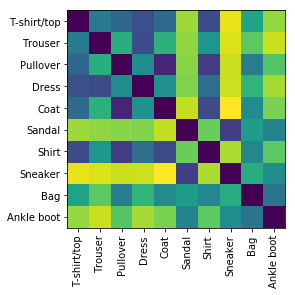

In [36]:
diff = np.zeros(shape = (10,10))

for i in np.unique(y):
    for j in np.unique(y):
        ig = pairwise_distances(np.concatenate((pca.transform(X)[y==i],pca.transform(X)[y==j]), axis=0))[1000:,:1000]        
        diff[i,j] = np.mean(ig)
        
ig = pairwise_distances(diff)

plt.imshow(ig)
plt.xticks(np.arange(10), y_to_labels(np.arange(10)), rotation=90)
plt.yticks(np.arange(10), y_to_labels(np.arange(10)))
plt.show()

Shirts indeed seem to be close to other groups but trousers do not seem to be the most distant group. In fact other groups like Sandals and Sneakers appear to be more distant than the rest. Maybe we could improve our classification score if we leverage this difference in distances between groups, alas, we should use K nearest neighbors.

In [37]:
neigh = KNeighborsClassifier(n_neighbors=5)
%time neigh.fit(pca.transform(X), y)
%time neigh.predict(pca.transform(X))
confusion_matrix(y, neigh.predict(pca.transform(X)))
"The accuracy of the kNN method with the PCA-reduced dataset is %s"%(accuracy_score(y, neigh.predict(pca.transform(X))))

Wall time: 71.7 ms
Wall time: 1.12 s


'The accuracy of the kNN method with the PCA-reduced dataset is 0.8743'

This methodology improved the training (or in this case the prediction time) as well as the accuracy considerably.

### Feature Extraction

Let's take some time to analyze other techniques for image feature extraction.

#### Edge Detection using Sobel Filters

An edge detection filter utilizes the gradient to find out the changes in magnitude between adjacent pixels. The specific filter we use here does a vertical and horizontal sweep and then retrieves the magnitude. Since our images are monochromatic and there's no radical change of color inside the items, we would expect to extract the outline of the figures on this filters.

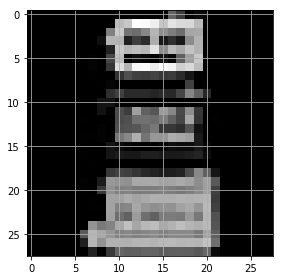

In [38]:
# Randomly choose an image from the data set
idx_to_reconstruct = int(np.random.rand(1)*len(X))

# Reshape and plot the image (randomly) selected
img  = X[idx_to_reconstruct].reshape((h,w))
imshow(img)
plt.grid()

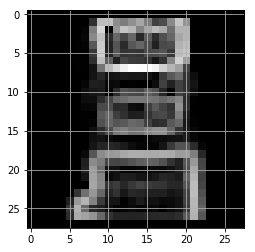

In [39]:
# Compute the magnitude of the gradient, then plot it to show edges of image
gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
plt.imshow(gradient_mag, cmap=plt.cm.binary_r)
plt.grid()

Why would we do this? May be there are some pixels that are redundant or carry no information and distract our learning algorithms. Let's try retraining our algorithm to check if this theory is correct.

In [40]:
edges = np.zeros(shape = X.shape)
for i in np.arange(X.shape[0]):
    edge = np.sqrt(sobel_v(X[i].reshape((h,w)))**2 + sobel_h(X[i].reshape((h,w)))**2 )
    edges[i] = edge.reshape(-1)

Now that we have the features let's see if the algorithm performs well without any sort of dimensionality reduction:

In [42]:
clf_edge = SGDClassifier(loss="log")
clf_edge.fit(edges, y)
y_pred_edge = clf_edge.predict(edges)
"The accuracy of the model with edge detection is %s"%(accuracy_score(y, y_pred_edge))

'The accuracy of the model with edge detection is 0.7883'

It appears that the accuracy of the model is about the same so we can conclude that little to none information was lost when extracting the edges. Let's see if we can get a similar score with less features by running the results from the previous filters through a PCA:

In [43]:
edge_pca = PCA(n_components=n_components)
edge_pca.fit(edges)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [44]:
clf_edge_pca = LogisticRegression() 
clf_edge_pca.fit(edge_pca.transform(edges), y)
y_pred_edge_pca = clf_edge_pca.predict(edge_pca.transform(edges))
"The accuracy of the model with edge detection and PCA is %s"%(accuracy_score(y, y_pred_edge_pca))

'The accuracy of the model with edge detection and PCA is 0.7778'

This is a significant decrease in performance. Our theory has been disproven. Could it be becuase the PCA of the new features explain less variance?

In [45]:
edge_pca.explained_variance_ratio_.sum()

0.69269929453788748

The PCA of the features derived from the edge detection filter explain less variance. This could be the reason (but not necessarily) for the decrease in prediciton performance. With that being said, we can conclude that edge detection does not seem to be helping to enhance the predictive power of our model.

#### DAISY

Next, let's compare another feature extraction method: the DAISY operator. This method works by extracting features based on localized color intensity histograms along different axes. In contrast with the other methods we have revised (but similar to the gamma parameter of the radial basis function kernel PCA), the performance of the DAISY operator relies heavily on the configuration of several hyperparameters. We will try two different configurations and compare results.

Our first configuration will measure histograms separated by 10 pixels. Our measurements will consist of 4 rings and we will measure histograms along 4 orientations. For a reference see the image below:

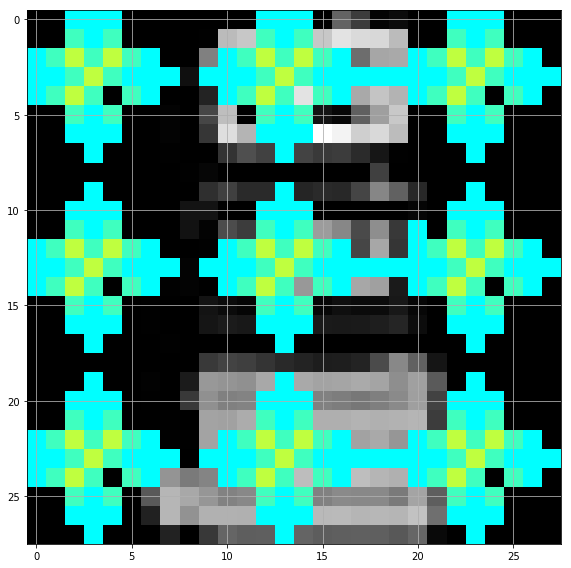

In [46]:
features, img_desc = daisy(img, step=10, radius=3, rings=4, histograms=4, orientations=4, visualize=True)
plt.figure(figsize=(8, 8))
imshow(img_desc)
plt.grid()

Our second configuration will apply it's measurements as drawn below:

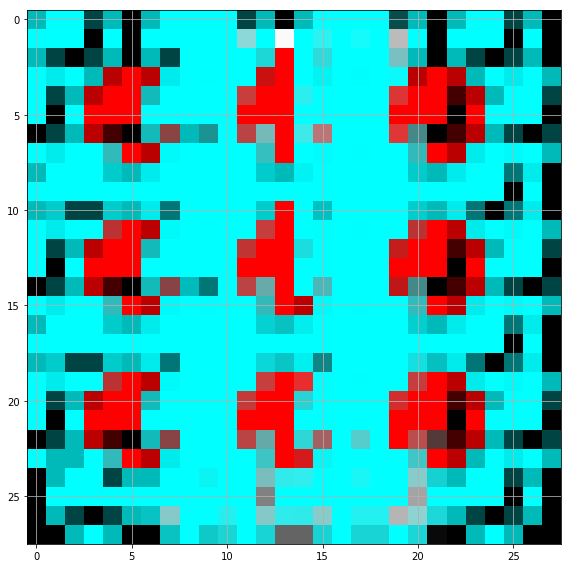

In [47]:
# Visualizing the DAISY descriptors
#features, img_desc = daisy(img, step=10, radius=3, rings=3, histograms=5, orientations=2, visualize=True)
features, img_desc = daisy(img, step=8, radius=5, rings=1, histograms=6, orientations=8, visualize=True)
plt.figure(figsize=(8, 8))
imshow(img_desc)
plt.grid()

In [48]:
def apply_daisy(row, shape, step, radius, rings, histograms, orientations):
    #feat = daisy(row.reshape(shape), step=10, radius=3, rings=3, histograms=5, orientations=2, visualize=False)
    feat = daisy(row.reshape(shape), step=step, radius=radius, rings=rings, histograms=histograms, orientations=orientations, visualize=False)
    return feat.reshape((-1))

In [49]:
%time daisy_features_1 = np.apply_along_axis(apply_daisy, 1, X, (h, w), step=10, radius=3, rings=4, histograms=4, orientations=4)
print(daisy_features_1.shape)

Wall time: 17.2 s
(10000, 612)


In [50]:
%time daisy_features_2 = np.apply_along_axis(apply_daisy, 1, X, (h, w), step=8, radius=5, rings=1, histograms=6, orientations=8)
print(daisy_features_2.shape)

Wall time: 16.2 s
(10000, 504)


We can see that the resulting feature space has been reduced in both cases, from 784 to 612 and 504 respectively. Let's see if our prediction accuracy increases or decreases with these new reduced feature spaces:

In [52]:
clf_daisy_1 = SGDClassifier(loss="log")
clf_daisy_1.fit(daisy_features_1, y)
y_pred_daisy_1 = clf_daisy_1.predict(daisy_features_1)
"The accuracy of the model with the first configuration of DAISY is %s"%(accuracy_score(y, y_pred_daisy_1))

'The accuracy of the model with the first configuration of DAISY is 0.8163'

In [54]:
clf_daisy_2 = SGDClassifier(loss="log")
clf_daisy_2.fit(daisy_features_2, y)
y_pred_daisy_2 = clf_daisy_2.predict(daisy_features_2)
"The accuracy of the model with the second configuration of DAISY is %s"%(accuracy_score(y, y_pred_daisy_2))

'The accuracy of the model with the second configuration of DAISY is 0.7673'

It appears as if the first configuration was marginally better than the second one, however we cannot justified the use of these transformations with these scores as we are using way too many variables. Let's try to see if we can further reduce the dimensionality with PCA and mantain the scores.

In [59]:
daisy_1_pca = PCA(n_components=n_components)
daisy_1_pca.fit(daisy_features_1)
clf_daisy_1_pca = LogisticRegression() 
clf_daisy_1_pca.fit(daisy_1_pca.transform(daisy_features_1), y)
y_pred_daisy_1_pca = clf_daisy_1_pca.predict(daisy_1_pca.transform(daisy_features_1))
"The accuracy of the model with the first configuration of DAISY and PCA is %s"%(accuracy_score(y, y_pred_daisy_1_pca))

'The accuracy of the model with the first configuration of DAISY and PCA is 0.7706'

In [56]:
daisy_2_pca = PCA(n_components=n_components)
daisy_2_pca.fit(daisy_features_2)
clf_daisy_2_pca = LogisticRegression() 
clf_daisy_2_pca.fit(daisy_2_pca.transform(daisy_features_2), y)
y_pred_daisy_2_pca = clf_daisy_2_pca.predict(daisy_2_pca.transform(daisy_features_2))
"The accuracy of the model with the second configuration of DAISY and PCA is %s"%(accuracy_score(y, y_pred_daisy_2_pca))

'The accuracy of the model with the second configuration of DAISY and PCA is 0.7638'

Again, the loss in accuracy was small if compared to the reduction of dimensionality. It is worth to notice that the second configuration retained almost the same accuracy after the PCA (this could be attributed to the stochastic process of the first set of models).

Finally let's see if at least these models were any better at detecting shirts:

In [57]:
for method, preds in {"DAISY Conf 1": y_pred_daisy_1, "DAISY Conf 2": y_pred_daisy_2}.items():
    item = y_to_labels(np.argmax(1000-np.diag((confusion_matrix(y, preds)))))
    mcr = np.max((1000-np.diag(confusion_matrix(y, preds)))/1000)
    print("The most misclassified item for the method [%s] was [%s] with a misclassification rate of %s"%(method, item, mcr))

The most misclassified item for the method [DAISY Conf 1] was [Shirt] with a misclassification rate of 0.676
The most misclassified item for the method [DAISY Conf 2] was [Shirt] with a misclassification rate of 0.99


Although these filters performed worse in the accuracy test and similar in the shirt misclassification rate than the original PCA-only models, we need to remember that the parameter configuration was arbitrary. We believe that a precise configuration or even a grid search would yield comparable if not better results.

Finally let's compare if all of these feature extraction made a difference in distancing different classes:

#### Feature Extraction: Gabor Kernels

Gabor filter is a linear filter used for texture analysis, which means that it basically analyses whether there are any specific frequency content in the image in specific directions in a localized region around the point or region of analysis. Frequency and orientation representations of Gabor filters are similar to those of the human visual system, and they have been found to be particularly appropriate for texture representation and discrimination.



In [60]:
# Prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                         sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)
            
# Compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _, _, feats[k, 0], feats[k, 1], feats[k, 2], feats[k, 3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurtosis
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1) * len(X))

gabor_feature = compute_gabor(X[idx_to_reconstruct], kernels, (h, w))
gabor_feature

array([  7.43150510e+01,   4.08358772e+03,   7.56689747e-02,
        -1.65871800e+00,   3.95127551e+01,   3.51078145e+03,
         2.81781806e+00,   7.39176999e+00,   4.99196429e+01,
         1.18743798e+03,   1.93453612e-01,  -1.39485947e+00,
         6.04528061e+01,   1.13196044e+04,   1.24262421e+00,
        -4.49706117e-01,   7.43048469e+01,   4.09362726e+03,
         7.61430252e-02,  -1.65740222e+00,   4.25204082e+01,
         4.17611197e+03,   2.62898893e+00,   6.00045064e+00,
         5.03341837e+01,   1.33902483e+03,   9.92260908e-02,
        -1.41067999e+00,   3.85408163e+01,   8.27299961e+03,
         1.95465823e+00,   1.82114542e+00,   7.43163265e+01,
         4.10156520e+03,   7.48942649e-02,  -1.65679570e+00,
         5.49260204e+01,   5.96548111e+03,   1.95978620e+00,
         2.35842307e+00,   8.66224490e+01,   5.71533365e+03,
         1.28748264e+00,   6.93446817e-01,   9.96632653e+01,
         1.48510052e+04,   4.54744982e-01,  -1.79089749e+00,
         7.43073980e+01,

In [61]:
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, (h, w))
print(gabor_stats.shape)

Wall time: 3min 15s
(10000, 64)


We can see that the resulting feature space has been reduced largely using the gabor kerner, from 784 to 64. Let's see how our prediction accuracy changes with application of this filter.

In [65]:
clf_gabor= SGDClassifier(loss="log")
clf_gabor.fit(gabor_stats, y)
y_pred_gabor = clf_gabor.predict(gabor_stats)
"The accuracy of the model with GABOR Kernel is %s"%(accuracy_score(y, y_pred_gabor))

'The accuracy of the model with GABOR Kernel is 0.5466'

Even though the gabor filter did reduce the feature space but it has done so at the cost of accuracy. The gabor filter gives us an accuracy of just 54%.

Lets try using PCA with the gabor filter and see if we can imporve the accuracy of prediction.

In [64]:
gabor_pca = PCA(n_components=n_components)
gabor_pca.fit(gabor_stats)
clf_gabor_pca = LogisticRegression() 
clf_gabor_pca.fit(gabor_pca.transform(gabor_stats), y)
y_pred_gabor_pca = clf_gabor_pca.predict(gabor_pca.transform(gabor_stats))
"The accuracy of the model with GABOR Kernel operator and PCA is %s"%(accuracy_score(y, y_pred_gabor_pca))

'The accuracy of the model with GABOR Kernel operator and PCA is 0.7454'

Applying PCA on the gabor filter has done a suprising great job. Although Gabor had only 64 feature which were already few, PCA has reduced the number of features further and has also increased the accuracy of prediction from 54% to 74%. 

In [80]:
for method, preds in {"GABOR Kerner": y_pred_gabor, "GABOR with PCA": y_pred_gabor_pca}.items():
    item = y_to_labels(np.argmax(1000-np.diag((confusion_matrix(y, preds)))))
    mcr = np.max((1000-np.diag(confusion_matrix(y, preds)))/1000)
    print("The most misclassified item for the method [%s] was [%s] with a misclassification rate of %s"%(method, item, mcr))

The most misclassified item for the method [GABOR Kerner] was [Dress] with a misclassification rate of 0.91
The most misclassified item for the method [GABOR with PCA] was [Shirt] with a misclassification rate of 0.721


The Gabor Kernel has a very high misclassification rate of 0.91 for the "Dress". This is due to the poor accuracy of the gabor filter. However, with the PCA, the misclassification rate goes down significantly to 0.721 for "Shirt". This is however still not as good as the original PCA model but that may be because gabor is used for texture analysis and our images are too small and have a low quality. Hence, gabor filter may not be very useful for us.

In [70]:
daisy_features_1_sub = np.apply_along_axis(apply_daisy, 1, X_sub, (h, w), step=10, radius=3, rings=4, histograms=4, orientations=4)
daisy_features_2_sub = np.apply_along_axis(apply_daisy, 1, X_sub, (h, w), step=8, radius=5, rings=1, histograms=6, orientations=8)
edges_sub = np.zeros(shape = X_sub.shape)
for i in np.arange(X_sub.shape[0]):
    edge = np.sqrt(sobel_v(X_sub[i].reshape((h,w)))**2 + sobel_h(X_sub[i].reshape((h,w)))**2 )
    edges_sub[i] = edge.reshape(-1)
gabor_stats_sub = np.apply_along_axis(compute_gabor, 1, X_sub, kernels, (h, w))

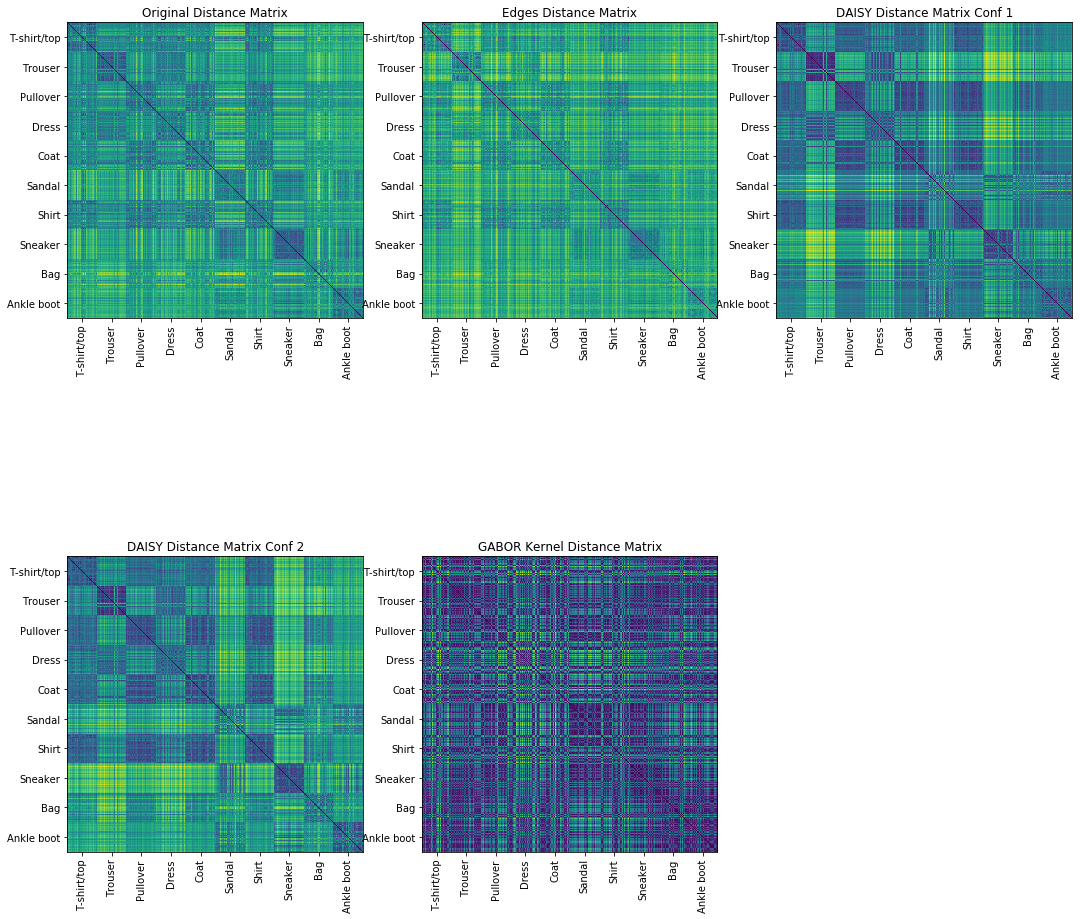

In [75]:
plt.figure(figsize=(18, 18))
plt.title("Distance Matrices")

plt.subplot(2,3,1)
plt.imshow(pairwise_distances(X_sub))
plt.xticks(np.arange(50,1000,100), y_to_labels(np.arange(10)), rotation=90)
plt.yticks(np.arange(50,1000,100), y_to_labels(np.arange(10)))
plt.title("Original Distance Matrix")

plt.subplot(2,3,2)
plt.imshow(pairwise_distances(edges_sub))
plt.xticks(np.arange(50,1000,100), y_to_labels(np.arange(10)), rotation=90)
plt.yticks(np.arange(50,1000,100), y_to_labels(np.arange(10)))
plt.title("Edges Distance Matrix")

plt.subplot(2,3,3)
plt.imshow(pairwise_distances(daisy_features_1_sub))
plt.xticks(np.arange(50,1000,100), y_to_labels(np.arange(10)), rotation=90)
plt.yticks(np.arange(50,1000,100), y_to_labels(np.arange(10)))
plt.title("DAISY Distance Matrix Conf 1")

plt.subplot(2,3,4)
plt.imshow(pairwise_distances(daisy_features_2_sub))
plt.xticks(np.arange(50,1000,100), y_to_labels(np.arange(10)), rotation=90)
plt.yticks(np.arange(50,1000,100), y_to_labels(np.arange(10)))
plt.title("DAISY Distance Matrix Conf 2")

plt.subplot(2,3,5)
plt.imshow(pairwise_distances(gabor_stats_sub))
plt.xticks(np.arange(50,1000,100), y_to_labels(np.arange(10)), rotation=90)
plt.yticks(np.arange(50,1000,100), y_to_labels(np.arange(10)))
plt.title("GABOR Kernel Distance Matrix")

plt.show()

From this image we can see that, consistent with the results, the original data separated classes efficiently - i.e. every row/column has only one definite block with close to no distance (blue). This heatmap, however, shows that sneakers and sandals are pretty similar followed closesly by ankle boots and that shirts, coats and pullover tend to be similar (no surprise here). We can also see that bags are really different between each other.

The plot from the edge filter shows the same information as the original plot but with more noise, item groups on average seem to be closer to each other.

The two plots for DAISY seem to be encoding the same information. These plots, however, exacerbete the issue of similar distances across items. Once again, this could change if the parameters were chosen more carefully.

Finally, the Gabor filter plot shows that the there is a lot of misclassfication between the different classes. All the rows have more than one definite block with close to no distance. This might be just because the image size is too small for using the gabor filter. 

We can visualize what we've just conclude in the following set of graphs:

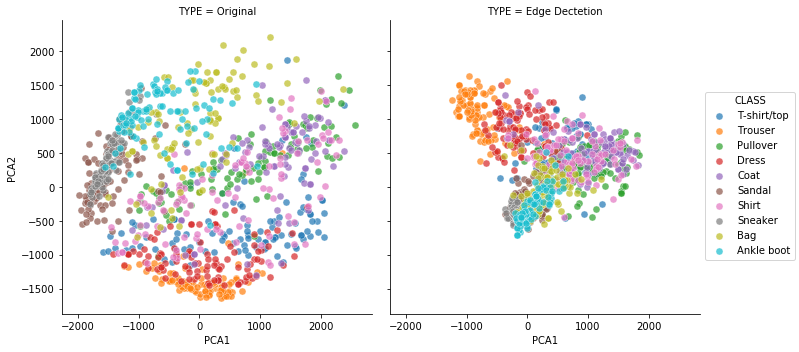

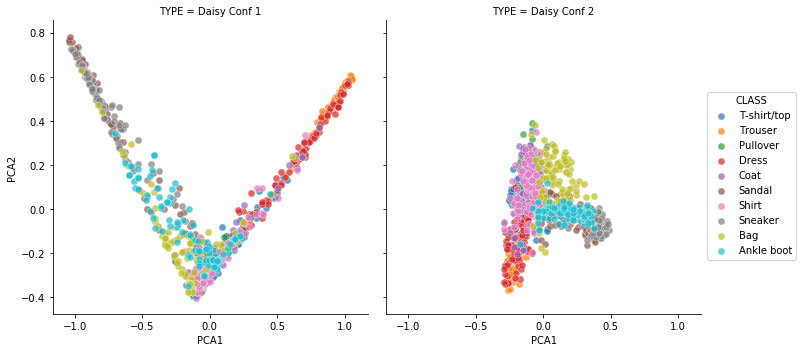

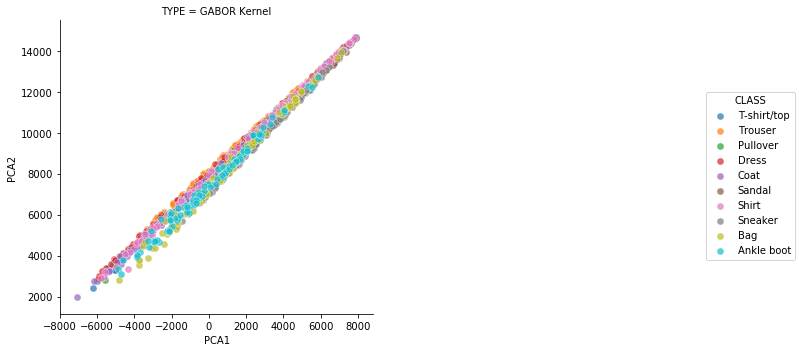

In [79]:
import seaborn as sns
df = pd.DataFrame(pca.transform(X_sub)).iloc[:,0:2]
df.columns = ["PCA1", "PCA2"]
df["CLASS"] = y_to_labels(y_sub)
df["TYPE"] = "Original"
df_ = pd.DataFrame(edge_pca.transform(edges_sub)).iloc[:,0:2]
df_.columns = ["PCA1", "PCA2"]
df_["CLASS"] = y_to_labels(y_sub)
df_["TYPE"] = "Edge Dectetion"
df = df.append(df_)

g = sns.FacetGrid(df, hue="CLASS", size=5, col="TYPE", col_wrap=2)
g.map(plt.scatter, "PCA1", "PCA2", s=50, alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend();
plt.show()

df = pd.DataFrame(daisy_1_pca.transform(daisy_features_1_sub)).iloc[:,0:2]
df.columns = ["PCA1", "PCA2"]
df["CLASS"] = y_to_labels(y_sub)
df["TYPE"] = "Daisy Conf 1"
df_ = pd.DataFrame(daisy_2_pca.transform(daisy_features_2_sub)).iloc[:,0:2]
df_.columns = ["PCA1", "PCA2"]
df_["CLASS"] = y_to_labels(y_sub)
df_["TYPE"] = "Daisy Conf 2"
df = df.append(df_)


e = sns.FacetGrid(df, hue="CLASS", size=5, col="TYPE", col_wrap=2)
e.map(plt.scatter, "PCA1", "PCA2", s=50, alpha=.7, linewidth=.5, edgecolor="white")
e.add_legend();
plt.show()

df = pd.DataFrame(gabor_pca.transform(gabor_stats_sub)).iloc[:,0:2]
df.columns = ["PCA1", "PCA2"]
df["CLASS"] = y_to_labels(y_sub)
df["TYPE"] = "GABOR Kernel"

f = sns.FacetGrid(df, hue="CLASS", size=5, col="TYPE", col_wrap=2)
f.map(plt.scatter, "PCA1", "PCA2", s=50, alpha=.7, linewidth=.5, edgecolor="white")
f.add_legend();
plt.show()